In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, get_panel_layout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [2]:
framepack_model = FramePack_1fmc(
    lora_path = "../../outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_1-step00003000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False


INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_1-step00003000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyu

Model, VAE, Text Encoders, LoRA loaded.


In [55]:
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20251004_200710_v2")
prev_output_path = Path("/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v2_multi_tmp_2000/en/20251018_220036")
story_num = '02'

# shutil.copytree(prev_output_path / story_num, f"tmp/{story_num}", dirs_exist_ok=True)
pose_layout = json.loads((main_layout_path / f"story_{story_num}/pose_layout.json").read_text())
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 2)

In [56]:
shot_num = 4

layout = pose_layout[f"{shot_num}"]
width, height = 1344, 768

panel_layout = {row['id']-1 : {
    'bbox' : list(map(lambda x: x/1000., [row['bbox']['x'], row['bbox']['y'], row['bbox']['x']+row['bbox']['w'], row['bbox']['y']+row['bbox']['h']])), 
    'body': []
} for row in layout['boxes']}
# panel_layout = {0: {'bbox': [0.8, 0.8, 0.9, 1.0], 'body': []}}
panel_layout = {0: {'bbox': [0.4, 0.2, 0.6, 1.0], 'body': []}}
# panel_layout = {1: {'bbox': [0.5, 0.3, 0.8, 0.9], 'body': []}, 0: {'bbox': [0.1, 0.1, 0.5, 0.9], 'body': []}, }
print(panel_layout)

story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt =";".join(prompt.split(";")[:3])
story_shot = vanila_shot
characters_shot = vanila_character_shot

print(prompt)
print(characters_shot)

{0: {'bbox': [0.4, 0.2, 0.6, 1.0], 'body': []}}
Illustration, Children's Picture Books;Medium close up, eye level shot;David plays in the bathtub, holding a toy boat, water splashing around, looking excited
{'David': {'name': 'David', 'key': 'David', 'prompt': 'A lively Caucasian boy with blond hair and blue eyes, about five or six years old, always wearing a mischievous smile. He is dressed in a simple T-shirt and shorts, often wearing small sneakers, sometimes covered in mud or water stains, looking a bit messy but full of energy.', 'tag': 'unrealistic_human', 'num_of_appearances': 9, 'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David/00.jpg']}}


In [ ]:
seed = np.random.randint(2**31)
# seed = 204684050
result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=True, cache_layers=[
        'transformer_blocks.2',
        'transformer_blocks.8',
        'transformer_blocks.14'
    ],
    debug_name=f"story{story_num}_shot{shot_num}"
)
result_imgs[0].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
debug_imgs[0].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")
debug_imgs[0]

1024959012
tensor[1, 1, 4] x∈[0.200, 0.757] μ=0.489 σ=0.242 [[[0.400, 0.200, 0.600, 0.757]]]


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 4552, 3072] bf16 n=13983744 (27Mb) x∈[-16.375, 19.000] μ=-0.015 σ=0.852 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 35, 3072] bf16 n=107520 (0.2Mb) x∈[-1.104e+03, 460.000] μ=0.007 σ=9.750 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.312, 19.875] μ=-0.111 σ=0.961 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 4587, 4587] bf16 n=21040569 (40Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 4552, 256] n=1165312 (4.4Mb) x∈[-1.000, 1.000] μ=0.305 σ=0.638 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 4032, 256] n=1032192 (3.9Mb) x∈[-1.000, 1.000] μ=0.307 σ=0.637 cuda:0, tensor[1, 520, 256] n=133120 (0.5Mb) x∈[-1.000, 1.000] μ=0.295 σ=0.643 cuda:0], 'clean_latents': [(0, 520)], 'noise': [(520, 4552)], 'text_embeddings': [(4552, 4587)]})
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-

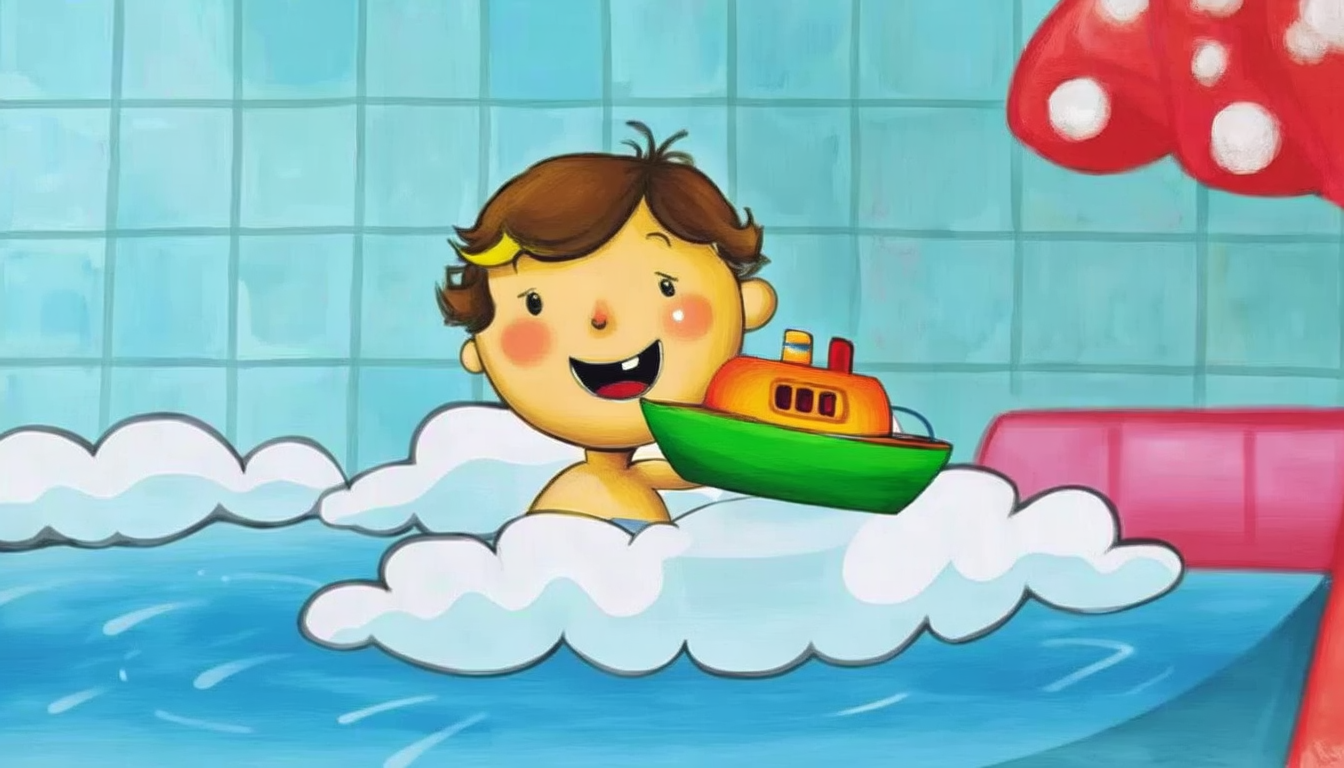

In [ ]:
from musubi_tuner.utils.bbox_utils import get_mask_from_bboxes
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout
from musubi_tuner.utils.preproc_utils import postproc_imgs, get_text_preproc, get_all_control_kwargs
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan

debug_dict = search_facebbox_for_layout(
    panel_layout, characters_shot, (width, height), 
    crop_face_detect=True, use_face_detect=False,
    c_width_given=320, scale_c=1.2, use_safety=True,
    bbox_mode='provided_size_mid_x')

entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(1)]
entitymask_nps = [get_mask_from_bboxes([entity_bbox], width, height) for entity_bbox in entity_bboxes]

# seed = np.random.randint(2**31)
print(seed)
text_kwargs = get_text_preproc(prompt, 
    framepack_model.text_encoder1, framepack_model.text_encoder2, framepack_model.tokenizer1, framepack_model.tokenizer2, 
    entity_prompts=[], device=framepack_model.device)

control_kwargs, entity_masks, control_nps, debug_mask, print_res = get_all_control_kwargs(
    panel_layout, characters_shot, framepack_model.vae, width=width, height=height,
    crop_face_detect=True, use_rembg=True, 
    c_width_given=320, bbox_mode='provided_size_mid_x',
    control_indices=[0], latent_indices=[3],
)
print(control_kwargs['clean_latent_bboxes'])
# control_kwargs['clean_latent_bboxes'] = torch.tensor([[[0.,0.,1.,1.]]])

generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator, 'device': framepack_model.device, 'dtype': framepack_model.dtype,
    'cache_results': True, 'cache_layers': [
        'transformer_blocks.2',
        'transformer_blocks.8',
        'transformer_blocks.14'
    ],
    'use_attention_masking': ['no_cross_control_latents', 'mask_control'],
    'entity_masks': entity_masks,
}
# attn_cache.clear()
results = sample_hunyuan(transformer=framepack_model.model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results[0:1], framepack_model.vae)[0])
result_img

# Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")

torch.Size([48, 84])


/tmp/ipykernel_3301506/236460945.py:23: RuntimeWarning: invalid value encountered in cast
  ax.imshow((attention_map.to(dtype=torch.float32).cpu().numpy()*255).astype(np.uint8), cmap='viridis')


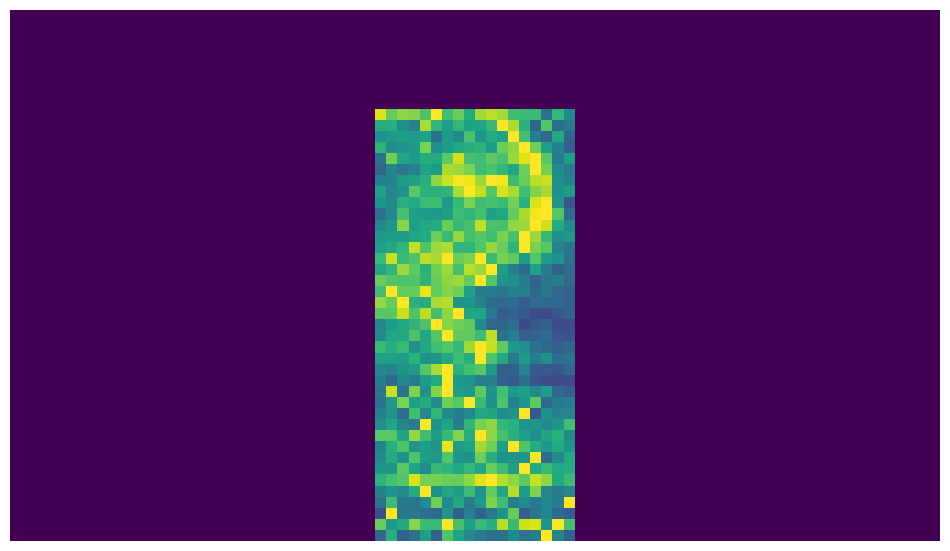

In [62]:
block_id=f'transformer_blocks.8'
t_0=0
t_1=25
normalize=True

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
clean_latent_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise']

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
attention_probs = sum(attn_cache[block_id][timesteps[t]][:,noise_inds[0][0]:noise_inds[0][1],:] for t in range(t_0, t_1))
attention_map = rearrange(attention_probs, 'B (H W) D -> B H W D', H=token_H, W=token_W)
attention_map = attention_map.permute(0,3,1,2)
attention_map = attention_map[0,clean_latent_inds[0][0]:clean_latent_inds[-1][1],:,:].mean(axis=0)

if normalize:
    attention_map -= attention_map.min(1, keepdim=True)[0]
    attention_map /= attention_map.max(1, keepdim=True)[0]
print(attention_map.shape)

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.imshow((attention_map.to(dtype=torch.float32).cpu().numpy()*255).astype(np.uint8), cmap='viridis')
ax.axis("off")
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

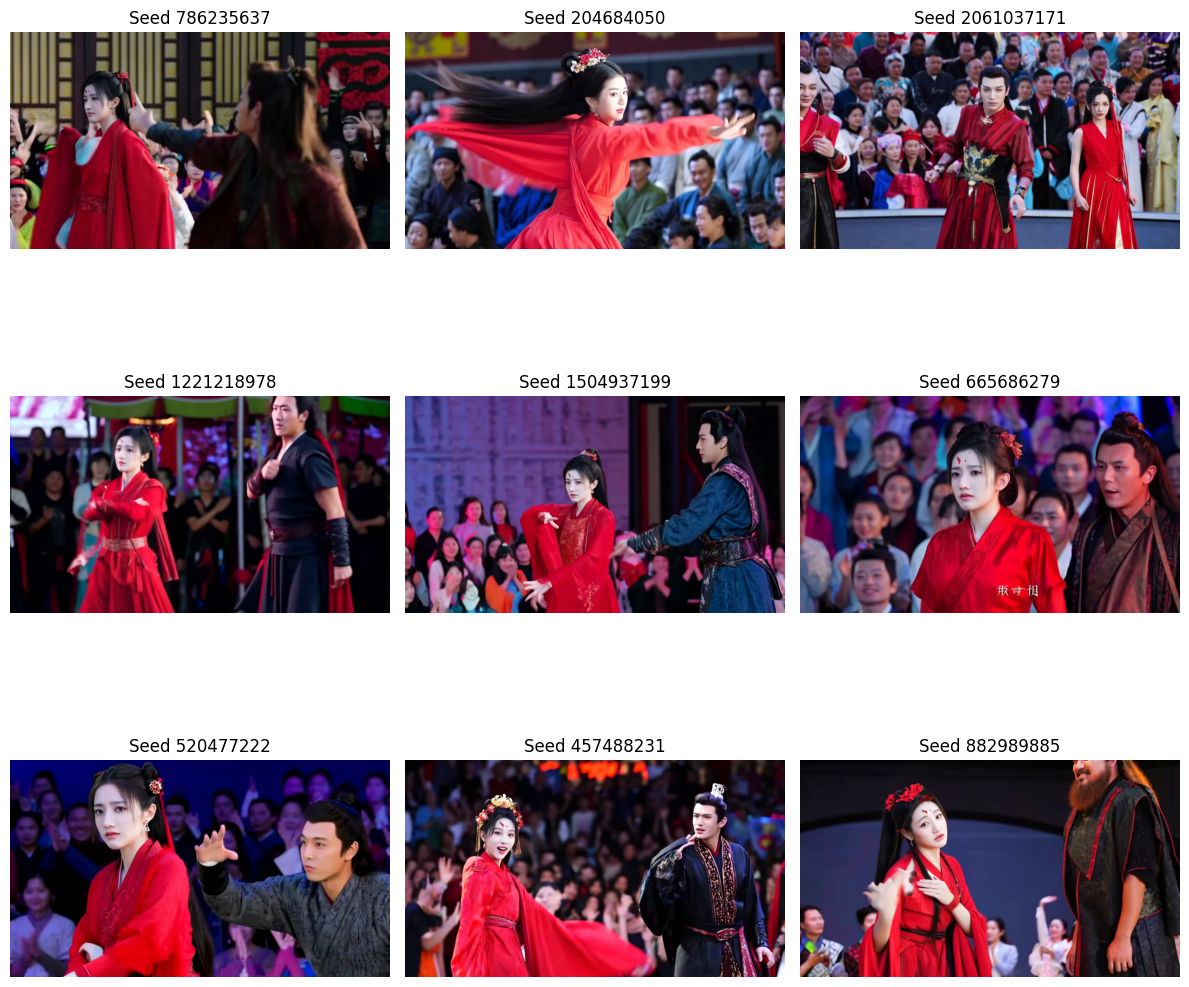

In [42]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 77
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v2_multi_tmp_2000/en/20251018_220036_v2/{story_num}_v2", 
    dirs_exist_ok=True
)

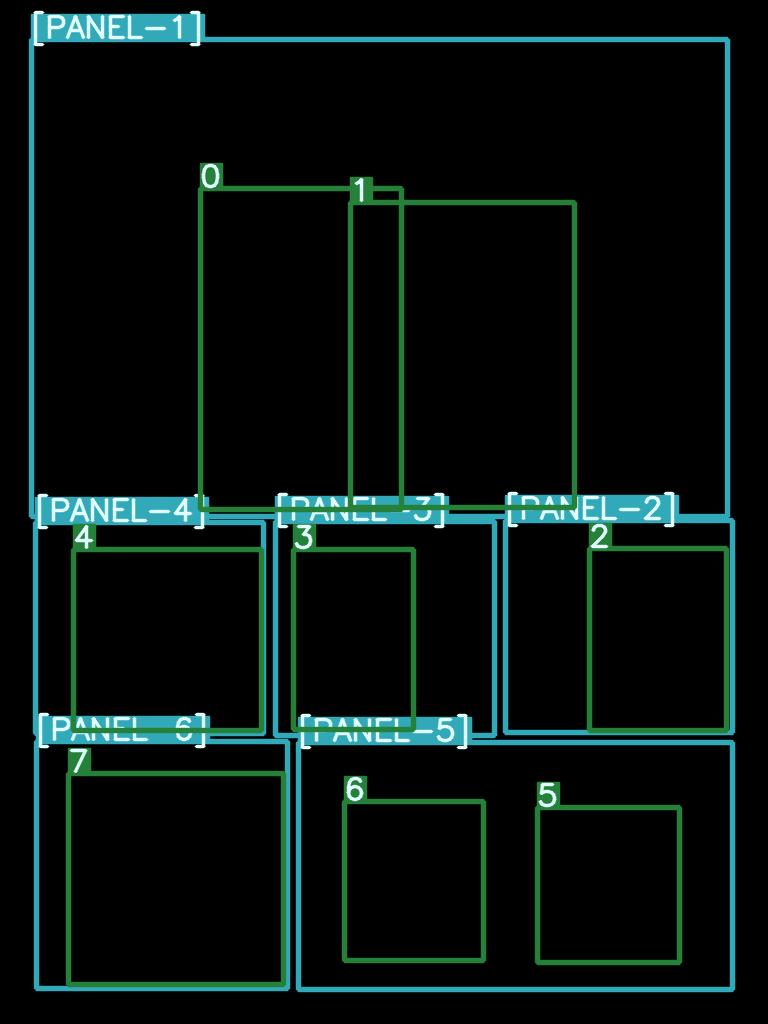

In [12]:
# tmp = {
#     "[PANEL-1]": {"bbox": [520, 40, 960, 380], "body" : [[180, 120, 900, 960]]},
#     "[PANEL-2]": {"bbox":  [40, 40, 500, 380], "body" : [[120, 420, 880, 820]]},
#     "[PANEL-3]": {"bbox": [40, 400, 960, 960], "body" : [[60, 200, 620, 980],[420, 260, 720, 880],[740, 280, 960, 860]]}
# }
tmp = json.loads(Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053/story_66-pages_1_6/pose_layout.json").read_text())


page_sub = convert_result_to_df_wpose(tmp, 768, 1024)
final_layout = annot_viz(Image.new("RGB", (768, 1024), (0,0,0)), page_sub, label_col='frame_id2')
final_layout

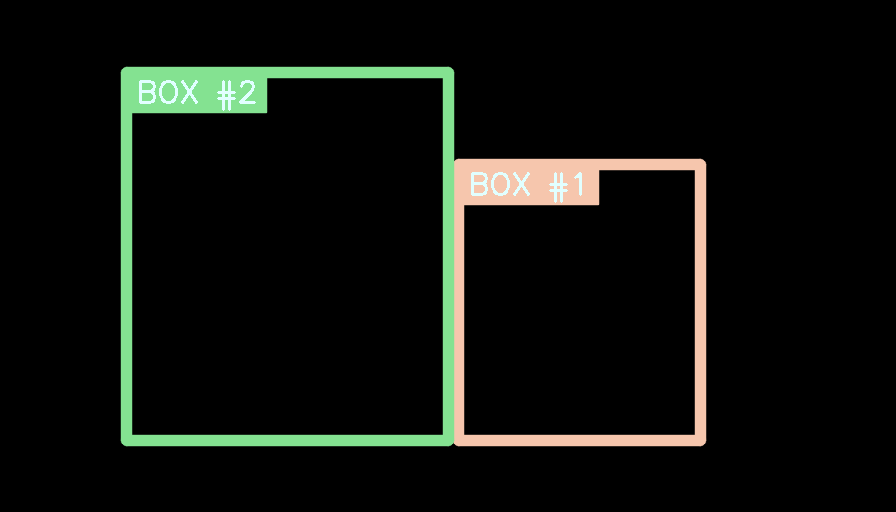

In [53]:
import cv2

annot_img = np.zeros((512, 896, 3), dtype=np.uint8)

row = page_sub.iloc[1]
c1, c2 = list(map(int, [row.xmin+10, row.ymin])), list(map(int, [row.xmax+10, row.ymax]))
cv2.rectangle(annot_img, c1, c2, (246,198,173), thickness=10, lineType=cv2.LINE_AA)
cv2.rectangle(annot_img, c1, (c1[0]+140, c1[1]+40), (246,198,173), -1, cv2.LINE_AA)  # filled
cv2.putText(annot_img, 'BOX #1', (c1[0]+10, c1[1]+30), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_4)


row = page_sub.iloc[2]
c1, c2 = list(map(int, [row.xmin, row.ymin])), list(map(int, [row.xmax, row.ymax]))
cv2.rectangle(annot_img, c1, c2, (132,226,145), thickness=10, lineType=cv2.LINE_AA)
cv2.rectangle(annot_img, c1, (c1[0]+140, c1[1]+40), (132,226,145), -1, cv2.LINE_AA)  # filled
cv2.putText(annot_img, 'BOX #2', (c1[0]+10, c1[1]+30), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_4)

Image.fromarray(annot_img)